In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

# Define a simple neural network
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 72s 37ms/step - loss: 0.1487 - accuracy: 0.9535 - val_loss: 0.0482 - val_accuracy: 0.9841
Epoch 2/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0448 - accuracy: 0.9861 - val_loss: 0.0374 - val_accuracy: 0.9877
Epoch 3/5
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0328 - accuracy: 0.9901 - val_loss: 0.0345 - val_accuracy: 0.9899
Epoch 4/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.0349 - val_accuracy: 0.9899
Epoch 5/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0201 - accuracy: 0.9934 - val_loss: 0.0312 - val_accuracy: 0.9901


In [ ]:
def fgsm_attack(image, epsilon, gradient):
    perturbation = epsilon * tf.sign(gradient)
    perturbed_image = image + perturbation
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

In [ ]:
def test(model, test_images, test_labels, epsilon):
    adv_examples = []
    correct = 0

    for i in range(len(test_images)):
        image = test_images[i]
        label = test_labels[i]

        image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)), dtype=tf.float32)
        label = tf.convert_to_tensor(label.reshape(1), dtype=tf.int64)

        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction, from_logits=True)

        gradient = tape.gradient(loss, image)
        perturbed_image = fgsm_attack(image, epsilon, gradient)
        adv_prediction = model(perturbed_image)
        adv_label = tf.argmax(adv_prediction[0]).numpy()

        if adv_label == label.numpy()[0]:
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_examples.append((image.numpy().squeeze(), perturbed_image.numpy().squeeze()))
        else:
            if len(adv_examples) < 5:
                adv_examples.append((image.numpy().squeeze(), perturbed_image.numpy().squeeze()))

    final_acc = correct / len(test_images)
    print(f'Epsilon: {epsilon}\tTest Accuracy = {final_acc:.4f}')

    return final_acc, adv_examples

In [ ]:
def test_and_find_misclassified(model, test_images, test_labels, epsilon=0.3):
    adv_examples = []
    misclassified = []
    correct = 0

    for i in range(len(test_images)):
        image = test_images[i]
        label = test_labels[i]

        image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)), dtype=tf.float32)
        label = tf.convert_to_tensor(label.reshape(1), dtype=tf.int64)

        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction, from_logits=True)

        gradient = tape.gradient(loss, image)
        perturbed_image = fgsm_attack(image, epsilon, gradient)
        adv_prediction = model(perturbed_image)
        adv_label = tf.argmax(adv_prediction[0]).numpy()

        if adv_label == label.numpy()[0]:
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_examples.append((image.numpy().squeeze(), perturbed_image.numpy().squeeze()))
        else:
            misclassified.append((image.numpy().squeeze(), label.numpy()[0], adv_label))
            if len(adv_examples) < 5:
                adv_examples.append((image.numpy().squeeze(), perturbed_image.numpy().squeeze()))

    final_acc = correct / len(test_images)
    print(f'Epsilon: {epsilon}\tTest Accuracy = {final_acc:.4f}')

    return final_acc, adv_examples, misclassified


Epsilon: 0.3	Test Accuracy = 0.1884


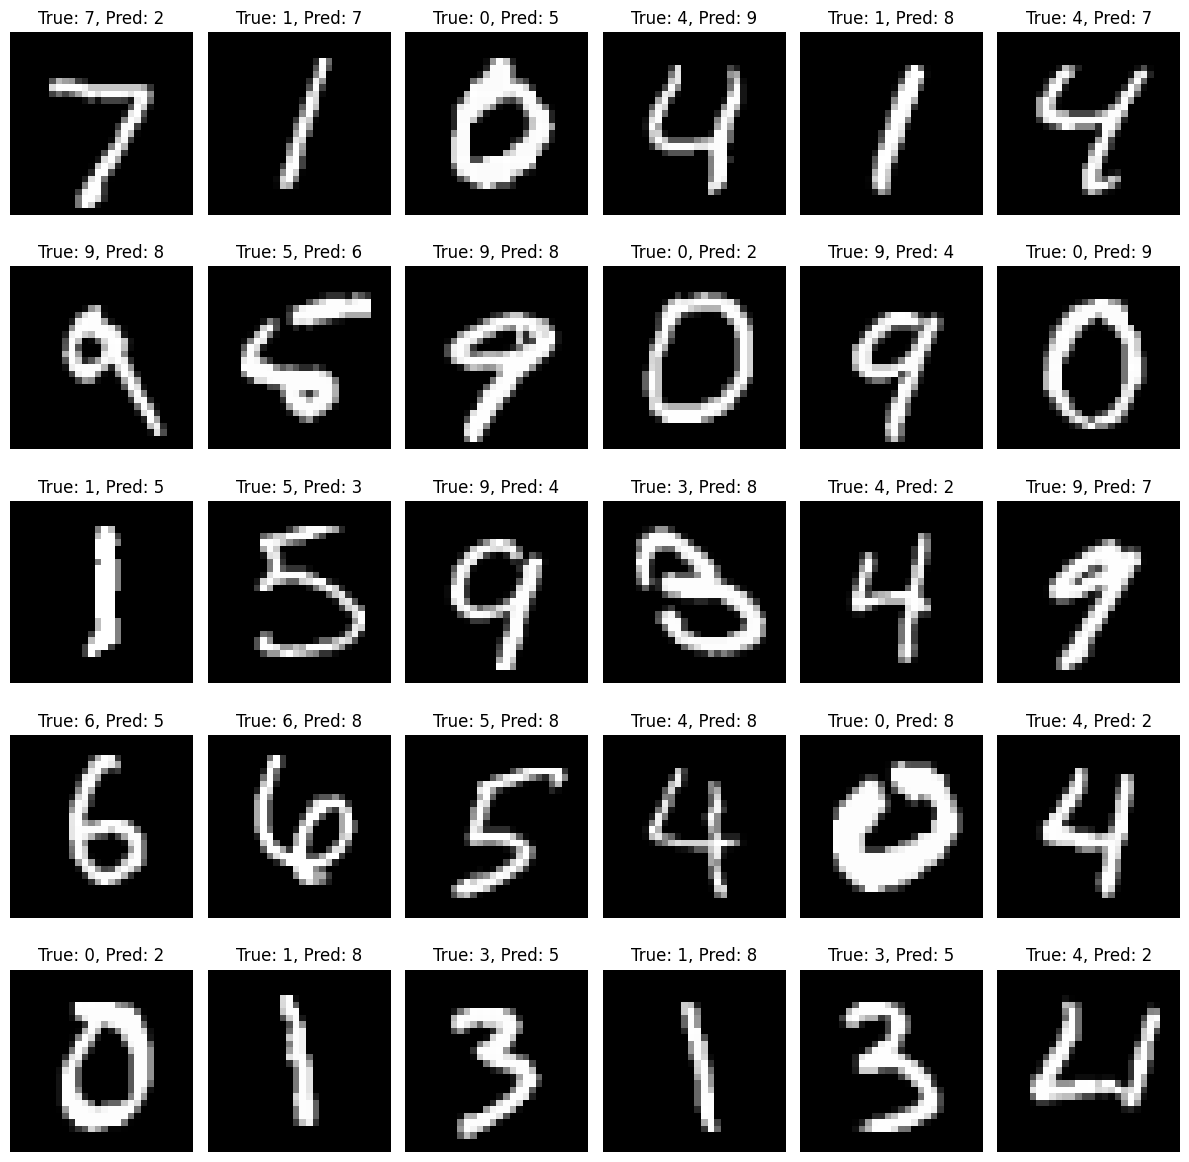

In [ ]:
epsilon = 0.3
accuracy, adv_examples, misclassified_images = test_and_find_misclassified(model, test_images, test_labels, epsilon)

# Display misclassified images
num_images_to_display = 30  # Set the number of misclassified images to display
plt.figure(figsize=(12, 12))

for i in range(min(num_images_to_display, len(misclassified_images))):
    original_image, true_label, adv_label = misclassified_images[i]
    plt.subplot(5, 6, i+1)
    plt.imshow(original_image, cmap="gray")
    plt.title(f'True: {true_label}, Pred: {adv_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()
